In [1]:
# load libraies

%run py_libraries.py

/Users/4476224/.local/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.13.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# loading utility files

from utility.sv_fig import savefig
from utility.make_cm import make_confusion_matrix
from utility.get_g_result import get_gamma_results
from utility.plt_result import plot_results

In [3]:
def savefig(filename, crop = True):
    plt.savefig('{}.pdf'.format(filename))

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)

# load data
# X_train = pd.read_csv('data/norm_X_train_NCa_Ca.csv')
# y_train = pd.read_csv('data/y_train_NCa_Ca.csv')

data = pd.read_csv('data/Xy_NCa_Ca_md.csv')

print(data.shape)

(91, 38)


In [5]:
# MI

In [6]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.model_selection import StratifiedKFold, KFold

# ---- Data ----
X = data.drop(columns=['CACHEXSTAGE0VIG'])
y = data['CACHEXSTAGE0VIG']

# Detect task type
is_classification = y.nunique() < 20 and not np.issubdtype(y.dtype, np.floating)

# Fill missing values (consistent across folds)
X_filled = X.fillna(0)

# ---- Cross-validation setup ----
n_splits = 5

if is_classification:
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
else:
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

mi_scores = []

# ---- CV loop ----
for fold, (train_idx, _) in enumerate(cv.split(X_filled, y)):
    X_train = X_filled.iloc[train_idx]
    y_train = y.iloc[train_idx]

    if is_classification:
        mi = mutual_info_classif(
            X_train,
            y_train,
            discrete_features='auto',
            random_state=42
        )
    else:
        mi = mutual_info_regression(
            X_train,
            y_train,
            random_state=42
        )

    mi_scores.append(mi)

# ---- Aggregate MI ----
mi_scores = np.vstack(mi_scores)

mi_df = pd.DataFrame(
    {
        "MI_mean": mi_scores.mean(axis=0),
        "MI_std": mi_scores.std(axis=0),
    },
    index=X.columns
).sort_values("MI_mean", ascending=False)

print("\n=== Cross-Validated Mutual Information Feature Ranking ===")
print(mi_df.round(10))



=== Cross-Validated Mutual Information Feature Ranking ===
               MI_mean    MI_std
Leptin        0.081403  0.036281
CA19.9        0.073382  0.033361
MIP.3a        0.065468  0.049516
IL.8          0.063597  0.019624
GDF.15        0.063031  0.053409
CRP           0.061634  0.027196
IL.22         0.059512  0.034995
Laminin       0.052041  0.017056
G.CSF         0.035528  0.029107
TGF.B2        0.033864  0.022460
TIMP.1        0.032081  0.021253
GRO.a         0.031008  0.036049
PPAR.y        0.030465  0.022673
Insulin       0.028947  0.035473
LDL           0.024365  0.018307
MMP.2         0.022730  0.029880
ZAG           0.021408  0.027334
IFN.y         0.020471  0.019346
Triglyceride  0.018639  0.035526
MCP.1         0.018181  0.022238
HGF           0.017120  0.031710
TNF.a         0.015851  0.019781
HDL           0.014610  0.029220
IL.10         0.013590  0.010842
HbA1c         0.009390  0.018780
MIP.1a        0.008589  0.017178
MDC           0.007407  0.010709
Albumin       0.

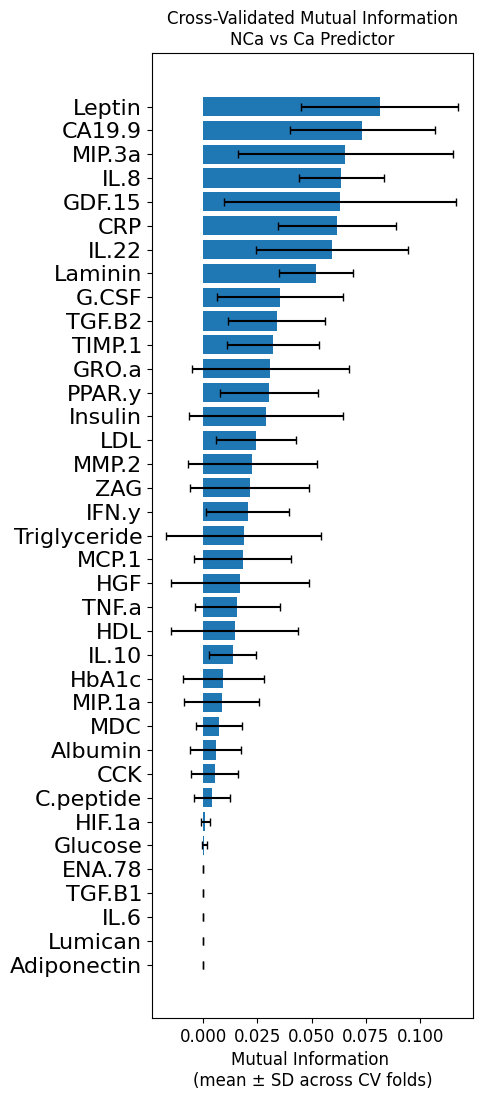

In [7]:
import matplotlib.pyplot as plt

# ---- Plot CV Mutual Information (mean ± std) ----
mi_plot = mi_df.sort_values("MI_mean")

plt.figure(figsize=(5, max(4, 0.3 * len(mi_plot))))

plt.barh(
    mi_plot.index,
    mi_plot["MI_mean"],
    xerr=mi_plot["MI_std"],
    capsize=3
)

plt.yticks(fontsize=16)
plt.xticks(fontsize=12) 

plt.xlabel("Mutual Information \n(mean ± SD across CV folds)", fontsize=12)
plt.title("Cross-Validated Mutual Information\nNCa vs Ca Predictor", fontsize=12)
plt.tight_layout()

plt.savefig("./figs/NCa_Ca_MI", dpi=300)
# plt.show()
